The objective is to solve the following optimization problem:
$$
V_k=\max_{\boldsymbol{u}} \min \{g(x),V_{k+1}(f(\boldsymbol{x},\boldsymbol{u},dt))\}.
$$
The variables and functions in the optimization problem are defined as follows:

- $\boldsymbol{u}$: Input vector of dimension $n \times 1$.
- $\boldsymbol{x}$: State vector of dimension $m \times 1$.
- $dt$: Discretization factor.
- $f(\boldsymbol{x}, \boldsymbol{u}, dt)$: System dynamics function that describes the state evolution.
- $V$: Value function.
- $g(\boldsymbol{x})$: Signed distance function.
- $k$: Time step.

## ploting functions 

In [21]:
# Function to plot heatmap of V for given time step k and theta index ti
function plot_V_heatmap(V, x_grid, y_grid, theta_grid, k, ti)
    # Extract the slice of V for specified k and ti
    V_slice = V[k, :, :, ti]  # V_slice[yi, xi]

    # Since V_slice is indexed by (yi, xi), and y_grid and x_grid correspond to yi and xi,
    # we can plot V_slice directly over x and y axes.

    # Create the heatmap
    heatmap(
        x_grid,        # x-axis values
        y_grid,        # y-axis values
        V_slice,       # V[yi, xi]
        xlabel = "x",
        ylabel = "y",
        title = "Value Function V at time step $k, θ = $(round(theta_grid[ti], digits=2))",
        colorbar = true,
        flip = false   # Ensure the orientation matches the grid
    )

    # Save and display the plot
    savefig("V_heatmap_k$(k)_theta$(ti).png")
    display(current())
end


function plot_policy_vector_field(policy, x_grid, y_grid, theta_grid, k, ti, delta_t; scaling_factor=1.0)
    # Extract the theta value
    theta = theta_grid[ti]
    
    num_x = length(x_grid)
    num_y = length(y_grid)
    total_points = num_x * num_y
    
    # Initialize arrays to hold positions and vector components
    X = zeros(total_points)
    Y = zeros(total_points)
    U = zeros(total_points)
    V = zeros(total_points)
    
    index = 1  # Index for the flattened arrays
    
    for xi in 1:num_x
        x = x_grid[xi]
        for yi in 1:num_y
            y = y_grid[yi]
                
            # Store the positions
            X[index] = x
            Y[index] = y
                
            # Extract the action from the policy
            action = policy[k, xi, yi, ti]
            omega, v = action
                
            # Handle undefined or NaN actions
            if isnan(omega) || isnan(v)
                U[index] = 0.0
                V[index] = 0.0
            else
                # Compute the vector components based on the action and theta
                dx = v * cos(theta) * delta_t
                dy = v * sin(theta) * delta_t
                    
                # Apply scaling factor to make arrows larger
                U[index] = dx * scaling_factor
                V[index] = dy * scaling_factor
            end
                
            index += 1
        end
    end
    
    # Create the quiver plot with correct argument placement
    quiver(
        X, Y;
        quiver = (U, V),
        xlabel = "x",
        ylabel = "y",
        title = "Policy Vector Field at time step $k, θ = $(round(theta, digits=2))",
        aspect_ratio = :equal,
        legend = false,
        arrow = :closed,       # Use closed arrowheads
        linewidth = 1.5,       # Increase the linewidth of arrows
        color = :blue,         # Set arrow color
        quiverkey = false
    )
    
    # Add boundary lines
    boundary_x = [minimum(x_grid), maximum(x_grid), maximum(x_grid), minimum(x_grid), minimum(x_grid)]
    boundary_y = [minimum(y_grid), minimum(y_grid), maximum(y_grid), maximum(y_grid), minimum(y_grid)]
    plot!(boundary_x, boundary_y, lc = :red, lw = 2, label = "Boundary")
    
    # Save and display the plot
    savefig("policy_vector_field_k$(k)_theta$(ti).png")
    display(current())
end

plot_policy_vector_field (generic function with 1 method)

## Dubin's Car dynamic 

The state of the system evolves according to the following equations:

\begin{aligned}
    \dot{x}&=  v \cdot \cos(\theta)\\
    \dot{y}&=  v \cdot \sin(\theta) \\
    \dot{\theta}&= \omega.
\end{aligned}

$\boldsymbol{x}$ = $[x, y, \theta]^T$
  - $x$: The current $x$-position of the car.
  - $y$: The current $y$-position of the car.
  - $\theta$: The orientation (heading angle) of the car, in radians.
    
$\boldsymbol{u}$ = $[\omega, v]^T$:
  - $\omega$: Angular velocity (rate of change of $\theta$.
  - $v$: Linear velocity (speed) of the car.


In [6]:
# Dynamics of Dubins's car
function dynamics(state, action, delta_t)
    x, y, theta = state
    omega, v = action  # Unpack the action tuple
    x_next = x + v * cos(theta) * delta_t
    y_next = y + v * sin(theta) * delta_t
    theta_next = theta + omega * delta_t
    return (x_next, y_next, theta_next)  # Return as a vector
end

dynamics (generic function with 1 method)

### Signed-Distance Function

The signed distance function $g(\boldsymbol{x})$ is defined based on whether the point $\boldsymbol{x} = (x, y, \theta)$ lies inside or outside a bounded set $M$, where:

$
M = \{(x, y, \theta) \mid x \in [\text{min}_x, \text{max}_x], y \in [\text{min}_y, \text{max}_y], \theta \in [\text{min}_\theta, \text{max}_\theta]\}.
$

#### Case 1: Point Inside the Set $g(\boldsymbol{x}) > 0$
If $\boldsymbol{x} \in M$, the signed distance is the minimum distance to the boundary of $M$:

$
g(\boldsymbol{x}) = \min \left\{ x - \text{min}_x, \text{max}_x - x, y - \text{min}_y, \text{max}_y - y, \theta - \text{min}_\theta, \text{max}_\theta - \theta \right\}.
$

#### Case 2: Point Outside the Set (\(g(\boldsymbol{x}) < 0\))
If $\boldsymbol{x} \notin M$, the signed distance is the negative Euclidean distance to the nearest point on the boundary of $M$:

$
g(\boldsymbol{x}) = -\sqrt{d_x^2 + d_y^2 + d_\theta^2},
$


#### Output:
The function returns $g(\boldsymbol{x})$, which represents the signed distance:
- Positive if the point is inside $M$.
- Negative if the point is outside $M$.

In [8]:
function g(state)
    x, y, theta = state
    # Define bounds for x and y
    min_x, max_x = -1.0, 1.0
    min_y, max_y = -1.0, 1.0
    # Define bounds for theta
    min_theta, max_theta = -Inf, Inf  # Example bounds; adjust as needed

    # Check if the point is inside the set M (the rectangular prism in x, y, theta space)
    if min_x ≤ x ≤ max_x && min_y ≤ y ≤ max_y && min_theta ≤ theta ≤ max_theta
        # Point is inside M
        # Compute s_M(z) = -inf_{y∈ℝ^m \ M} |z - y|
        # Distance to the closest point outside M (boundary)
        dx = min(x - min_x, max_x - x)
        dy = min(y - min_y, max_y - y)
        dtheta = min(theta - min_theta, max_theta - theta)
        distance = min(dx, dy, dtheta)
        signed_distance = distance
    else
        # Point is outside M
        # Compute s_M(z) = inf_{y∈M} |z - y|
        # Distance to the closest point inside M (boundary)
        dx = max(min_x - x, 0, x - max_x)
        dy = max(min_y - y, 0, y - max_y)
        # Handle periodicity of theta if applicable
        if theta < min_theta
            dtheta = min_theta - theta
        elseif theta > max_theta
            dtheta = theta - max_theta
        else
            dtheta = 0  # Inside theta bounds
        end
        # Total Euclidean distance in 3D space
        distance = sqrt(dx^2 + dy^2 + dtheta^2)
        signed_distance = -distance
    end

    return signed_distance
end

g (generic function with 1 method)

## Closest indices fucntion 

In [14]:
# Function to get the closest grid indices for a given state
function get_indices(state, x_grid, y_grid, theta_grid)
    x, y, theta = state
    x_idx = argmin(abs.(x_grid .- x))
    y_idx = argmin(abs.(y_grid .- y))
    # Handle theta wrapping around 2π
    # theta = mod(theta, 2pi)
    theta_diff = abs.(theta_grid .- theta)
    theta_idx = argmin(theta_diff)
    return x_idx, y_idx, theta_idx
end


get_indices (generic function with 1 method)

## Defining grids

In [9]:
# Define state bounds and grids
lower_x, upper_x = -1.0, 1.0
lower_y, upper_y = -1, 1
lower_omega, upper_omega = -2, 2
lower_v, upper_v = -1, 1

num_x, num_y, num_theta, num_omega, num_v = 20, 20, 16, 10, 10 # Grid resolution for x and y

x_grid=round.(range(lower_x, upper_x, length=num_x),digits=1)
y_grid=round.(range(lower_y, upper_y, length=num_y),digits=1)
omega_grid=range(lower_omega, upper_omega, length=num_omega)

v_grid=range(lower_v, upper_v, length=num_omega)

theta_grid = range(-pi, pi, length=num_theta)

-3.141592653589793:0.41887902047863906:3.141592653589793

### initilize the value function

In [10]:
time=5
delta_t=0.1
time_steps=Int(time/delta_t)
V = fill(NaN, time_steps + 1, num_x, num_y, num_theta)
policy = Array{Tuple{Float64, Float64}}(undef, time_steps, num_x, num_y, num_theta)

50×20×20×16 Array{Tuple{Float64, Float64}, 4}:
[:, :, 1, 1] =
 (0.0, 0.0)  (0.0, 0.0)  (0.0, 0.0)  …  (0.0, 0.0)  (0.0, 0.0)  (0.0, 0.0)
 (0.0, 0.0)  (0.0, 0.0)  (0.0, 0.0)     (0.0, 0.0)  (0.0, 0.0)  (0.0, 0.0)
 (0.0, 0.0)  (0.0, 0.0)  (0.0, 0.0)     (0.0, 0.0)  (0.0, 0.0)  (0.0, 0.0)
 (0.0, 0.0)  (0.0, 0.0)  (0.0, 0.0)     (0.0, 0.0)  (0.0, 0.0)  (0.0, 0.0)
 (0.0, 0.0)  (0.0, 0.0)  (0.0, 0.0)     (0.0, 0.0)  (0.0, 0.0)  (0.0, 0.0)
 (0.0, 0.0)  (0.0, 0.0)  (0.0, 0.0)  …  (0.0, 0.0)  (0.0, 0.0)  (0.0, 0.0)
 (0.0, 0.0)  (0.0, 0.0)  (0.0, 0.0)     (0.0, 0.0)  (0.0, 0.0)  (0.0, 0.0)
 (0.0, 0.0)  (0.0, 0.0)  (0.0, 0.0)     (0.0, 0.0)  (0.0, 0.0)  (0.0, 0.0)
 (0.0, 0.0)  (0.0, 0.0)  (0.0, 0.0)     (0.0, 0.0)  (0.0, 0.0)  (0.0, 0.0)
 (0.0, 0.0)  (0.0, 0.0)  (0.0, 0.0)     (0.0, 0.0)  (0.0, 0.0)  (0.0, 0.0)
 (0.0, 0.0)  (0.0, 0.0)  (0.0, 0.0)  …  (0.0, 0.0)  (0.0, 0.0)  (0.0, 0.0)
 (0.0, 0.0)  (0.0, 0.0)  (0.0, 0.0)     (0.0, 0.0)  (0.0, 0.0)  (0.0, 0.0)
 (0.0, 0.0)  (0.0, 0.0)  (0.0, 0.0)   

### Initialize terminal cost

In [12]:
for xi in 1:num_x
    for yi in 1:num_y
        for ti in 1:num_theta
            state = (x_grid[xi], y_grid[yi], theta_grid[ti])
            V[time_steps + 1, xi, yi, ti] = g(state)
        end
    end
end

# Dp

In [15]:
# Perform backward iteration to compute Value Function and Policy
for k in time_steps:-1:1
    println("Calculating optimal policy for time step $k")
    for (xi, x) in enumerate(x_grid)
        for (yi, y) in enumerate(y_grid)
            for (ti, theta) in enumerate(theta_grid)

                state = (x, y, theta)
                max_value = -Inf  # Correct initialization for maximization
                best_action = (NaN, NaN)
                
                for omega in omega_grid
                    for v in v_grid
                        # Compute the next state
                        next_state = dynamics(state, (omega, v), delta_t)
                        x_next, y_next, theta_next = next_state
                
                        # Get indices of the next state
                        x_next_idx, y_next_idx, theta_next_idx = get_indices(next_state, x_grid, y_grid, theta_grid)
                
                        # Check if indices are within bounds
                        if 1 ≤ x_next_idx ≤ num_x && 1 ≤ y_next_idx ≤ num_y && 1 ≤ theta_next_idx ≤ num_theta
                            # Retrieve the Value Function at the next state
                            V_next = V[k + 1, x_next_idx, y_next_idx, theta_next_idx]
                        else
                            V_next = -Inf  # Assign a penalty for out-of-bounds transitions
                        end
                
                        # Compute the signed distance at the current state
                        sign_distance = g(next_state)
                        # println(V_next,sign_distance)
                        # Compute future_value as the minimum between sign_distance and V_next
                        future_value = min(sign_distance, V_next)
                
                        # Update max_value and best_action if future_value is greater
                        if future_value > max_value
                            max_value = future_value
                            best_action = (omega, v)
                        end
                    end
                end
                
                # Update Value Function and Policy
                V[k, xi, yi, ti] = max_value
                policy[k, xi, yi, ti] = best_action
            end
        end
    end
end

Calculating optimal policy for time step 50
Calculating optimal policy for time step 49
Calculating optimal policy for time step 48
Calculating optimal policy for time step 47
Calculating optimal policy for time step 46
Calculating optimal policy for time step 45
Calculating optimal policy for time step 44
Calculating optimal policy for time step 43
Calculating optimal policy for time step 42
Calculating optimal policy for time step 41
Calculating optimal policy for time step 40
Calculating optimal policy for time step 39
Calculating optimal policy for time step 38
Calculating optimal policy for time step 37
Calculating optimal policy for time step 36
Calculating optimal policy for time step 35
Calculating optimal policy for time step 34
Calculating optimal policy for time step 33
Calculating optimal policy for time step 32
Calculating optimal policy for time step 31
Calculating optimal policy for time step 30
Calculating optimal policy for time step 29
Calculating optimal policy for t

### Ploting Value function for different time steps.

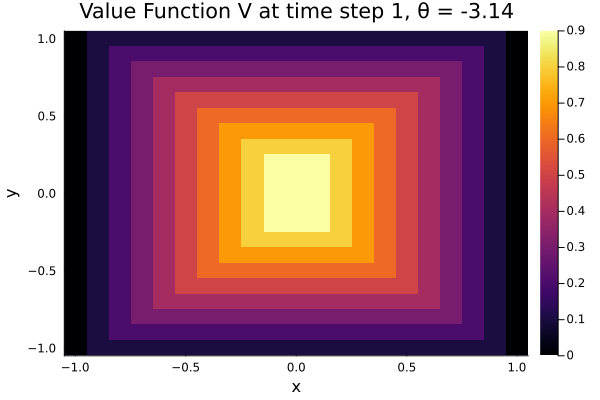

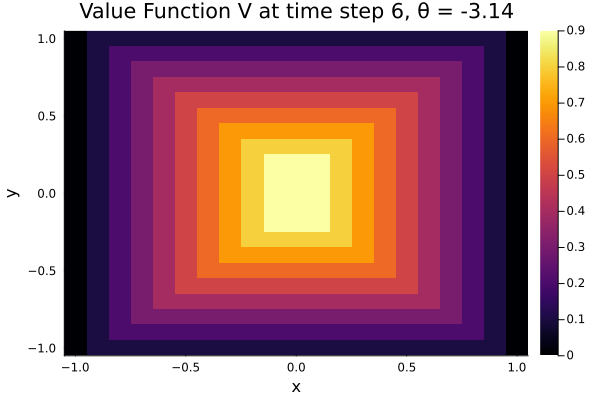

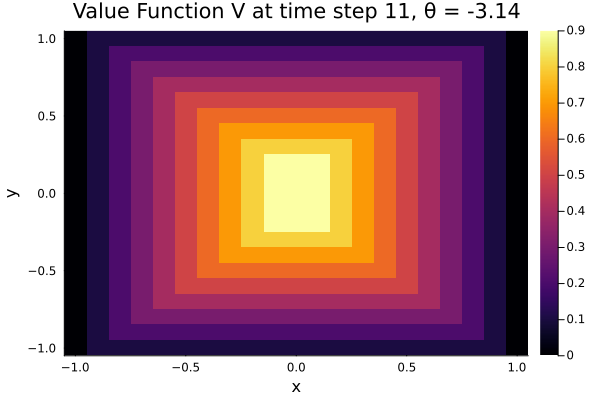

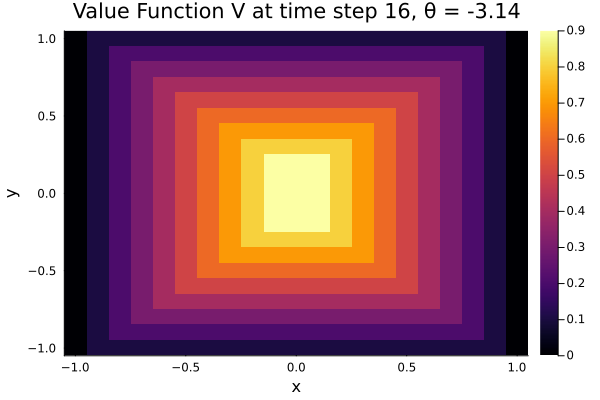

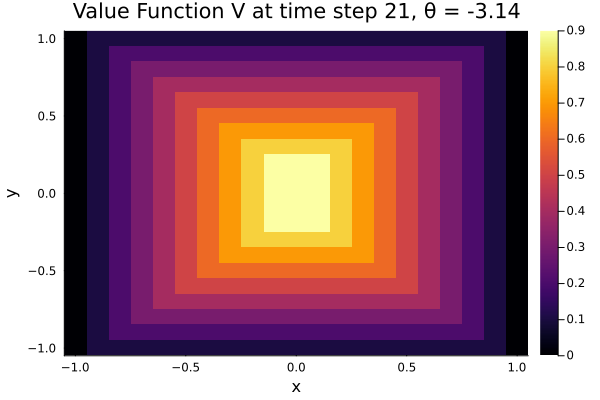

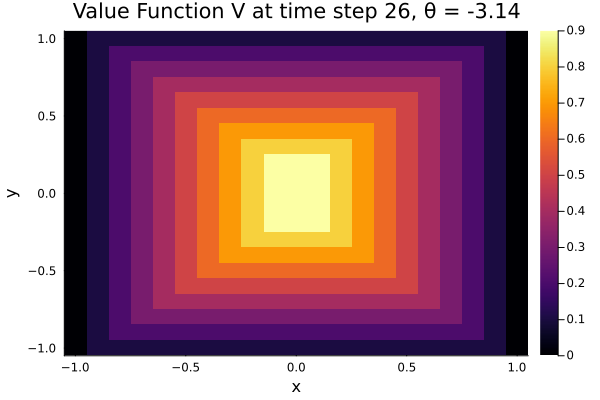

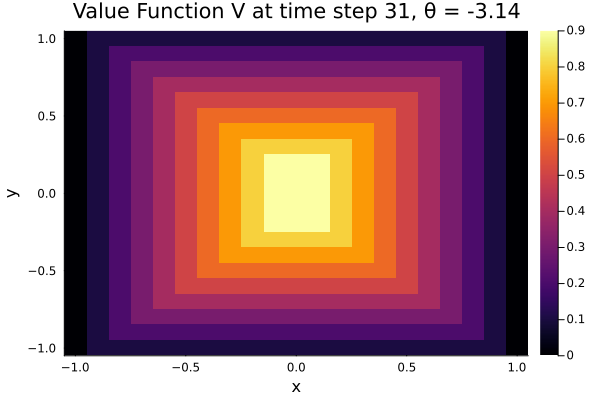

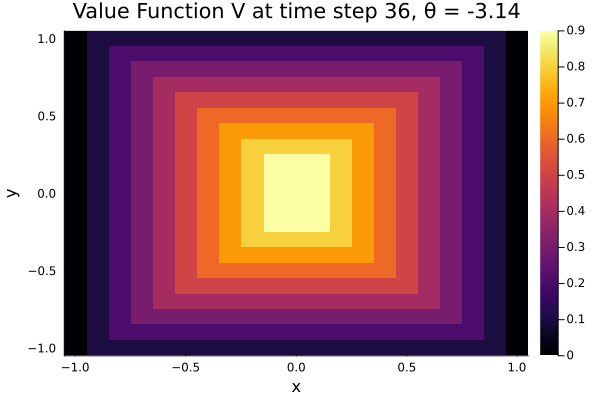

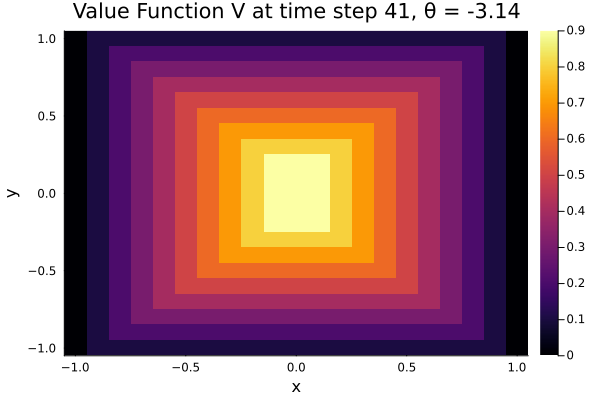

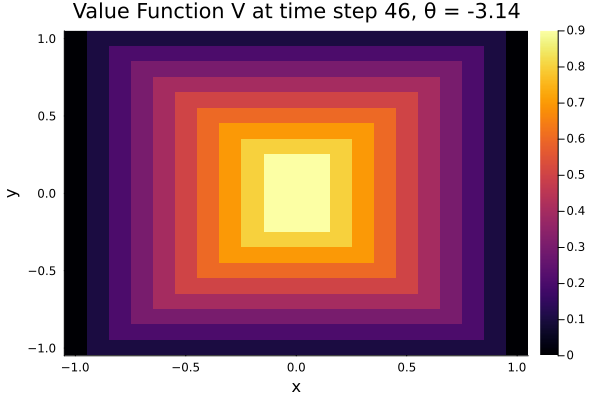

In [23]:
# Import necessary packages
using Plots
gr()  # Use the GR backend for plotting

for time in 1:5:time_steps
    plot_V_heatmap(V, x_grid, y_grid, theta_grid, time, 1)
end

### Ploting Value function for different theta.

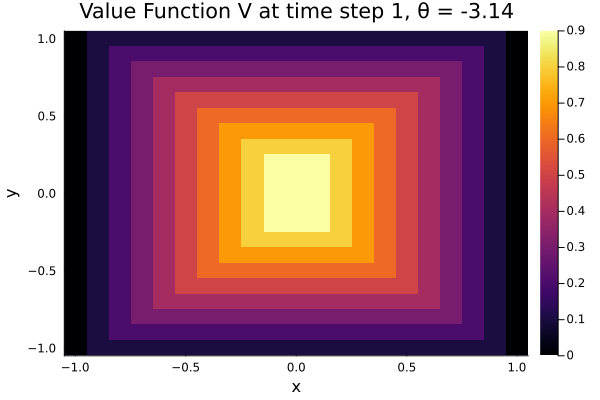

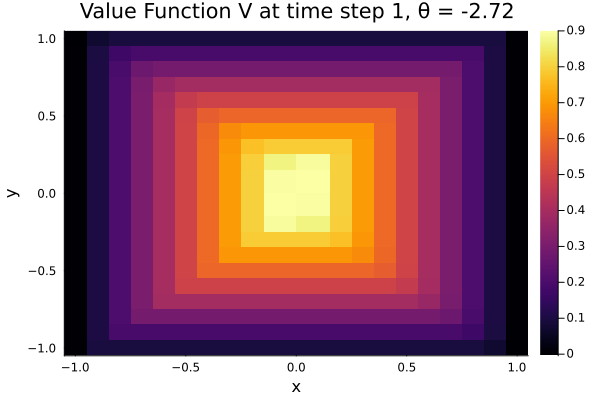

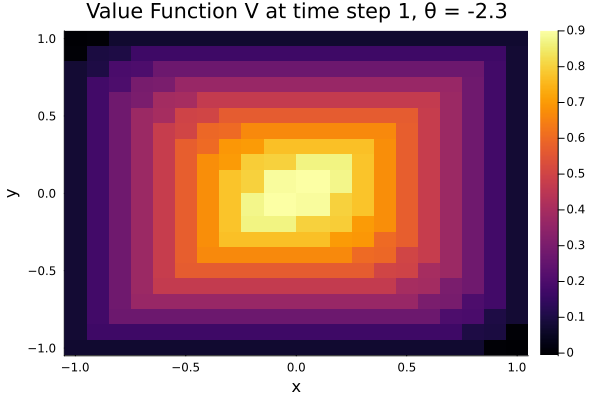

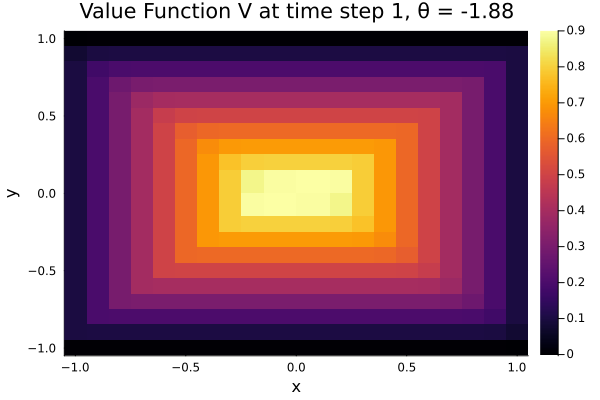

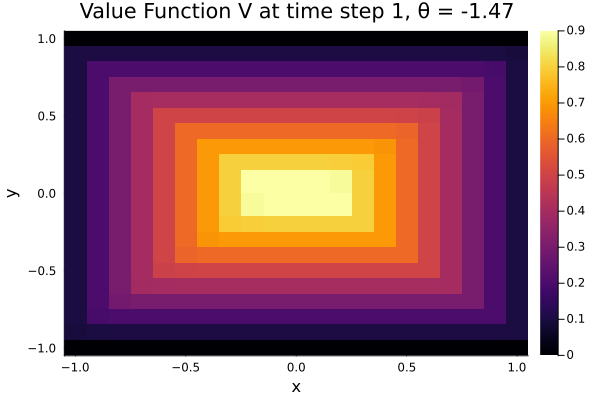

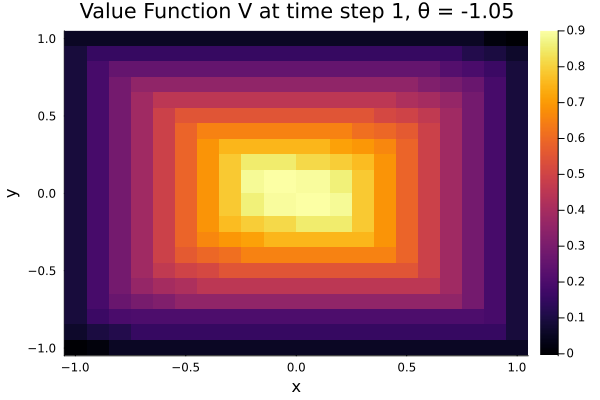

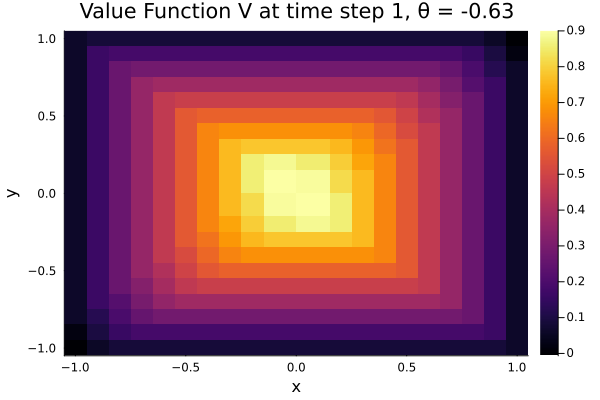

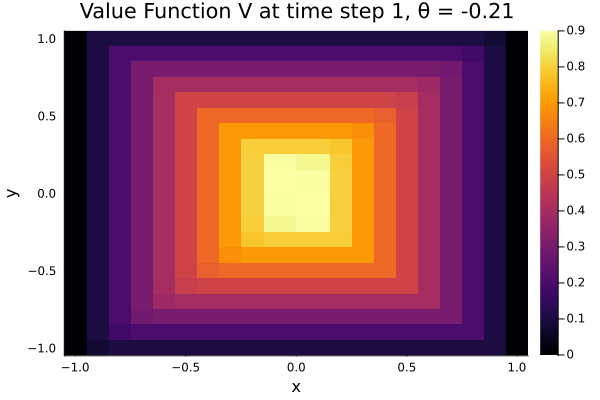

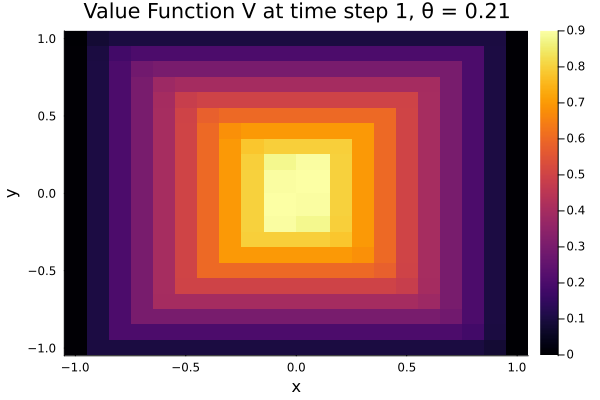

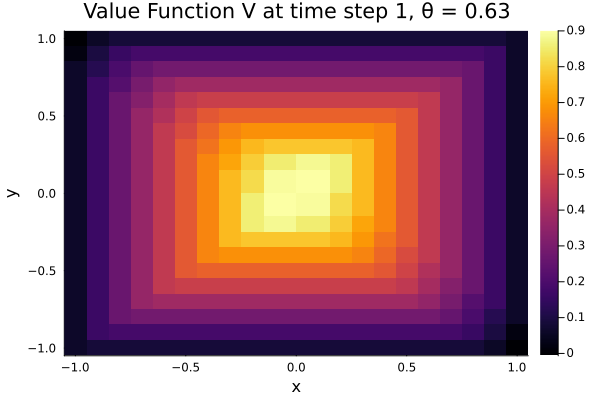

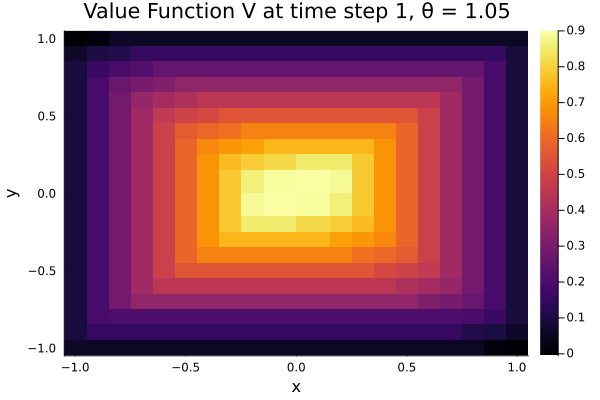

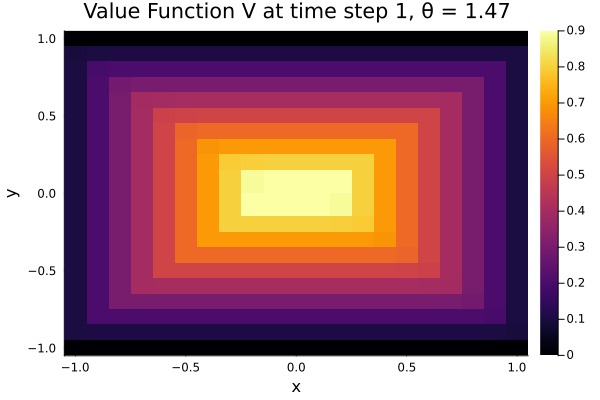

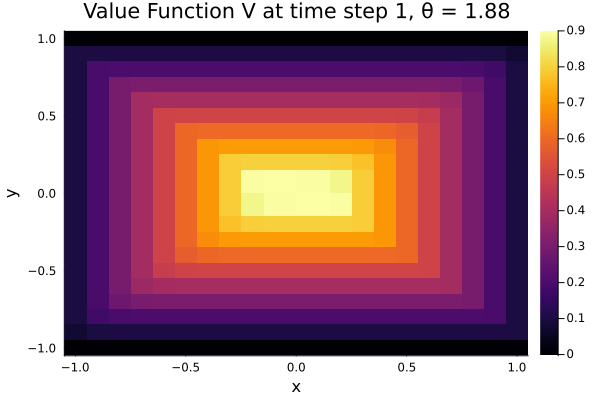

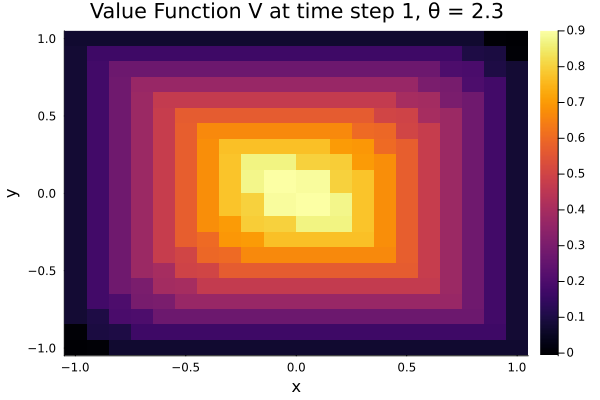

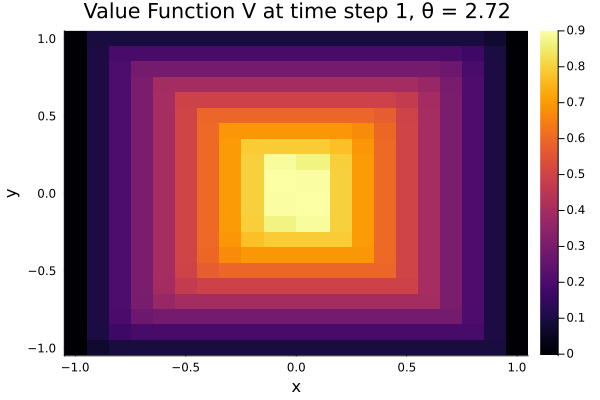

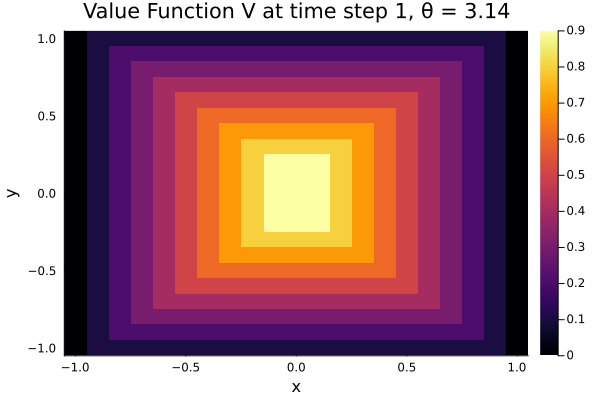

In [24]:
for ti in 1:length(theta_grid)
    plot_V_heatmap(V, x_grid, y_grid, theta_grid, 1, ti)
end

### Ploting Optimal Policy for different theta.

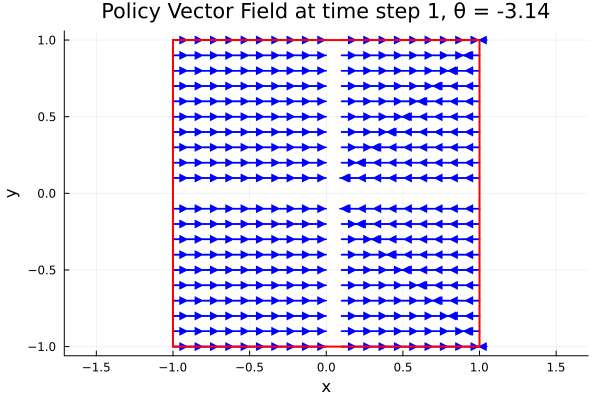

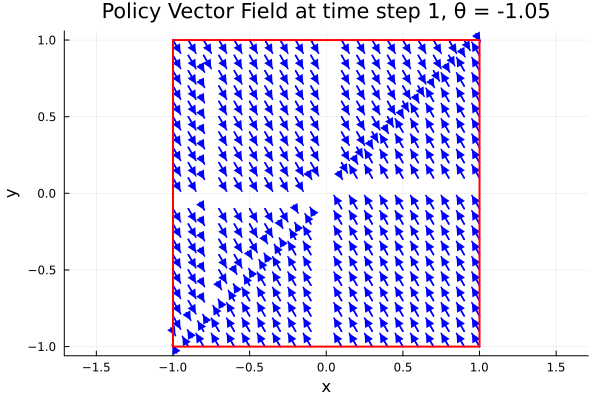

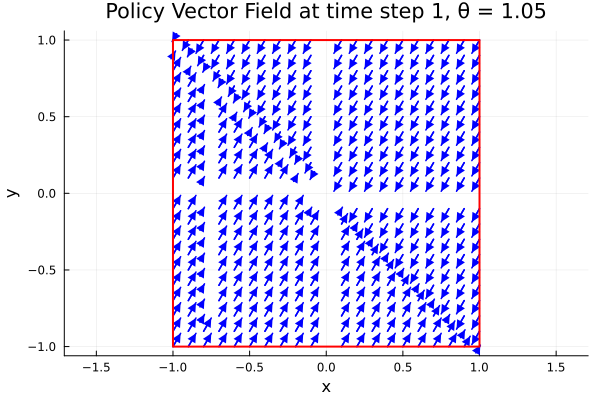

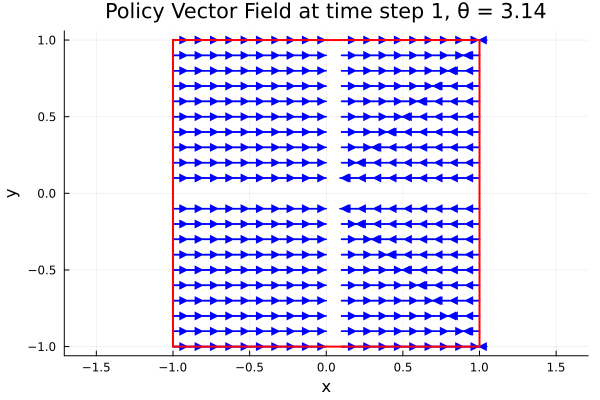

In [25]:
for ti in 1:5:length(theta_grid)
    plot_policy_vector_field(policy, x_grid, y_grid, theta_grid, 1, ti, delta_t)
end

## Simulation Function


In [26]:
function run_simulation_with_value_tracking(
    initial_state, policy, x_grid, y_grid, theta_grid, V, dynamics, delta_t, time_steps
)
    trajectory = [initial_state]
    inputs = Tuple{Float64, Float64}[]
    value_over_time = Float64[]
    signed_distance_over_time = Float64[]

    current_state = initial_state

    for k in 1:time_steps
        x, y, theta = current_state

        # Find the closest grid indices
        x_idx = argmin(abs.(x_grid .- x))
        y_idx = argmin(abs.(y_grid .- y))
        theta_idx = argmin(abs.(theta_grid .- theta))

        # Get the value of the current state from the value function
        value_current = V[k, x_idx, y_idx, theta_idx]
        push!(value_over_time, value_current)

        # Compute the signed distance at the current state
        signed_distance_current = g(current_state)
        push!(signed_distance_over_time, signed_distance_current)

        # Get the optimal action
        action = policy[k, x_idx, y_idx, theta_idx]
        omega, v = action

        # Check for NaN actions
        if isnan(omega) || isnan(v)
            println("No optimal action found for state ($x, $y, $theta) at time step $k. Stopping simulation.")
            break
        end

        # Apply dynamics to get next state
        next_state = dynamics(current_state, action, delta_t)
        x_next, y_next, theta_next = next_state

        # Wrap theta_next to [-π, π]
        theta_next = mod(theta_next + π, 2π) - π
        next_state = (x_next, y_next, theta_next)  # Create a new tuple with wrapped theta

        # Append the action and next state to the lists
        push!(inputs, action)
        push!(trajectory, next_state)

        current_state = next_state
    end

    return trajectory, inputs, value_over_time, signed_distance_over_time
end

run_simulation_with_value_tracking (generic function with 1 method)

### Set the initial state and Run the simulation

In [27]:
initial_state = (-0.5, 0.5,pi/2)

trajectory, inputs, value_over_time, signed_distance_over_time = run_simulation_with_value_tracking(
    initial_state, policy, x_grid, y_grid, theta_grid, V, dynamics, delta_t, time_steps
)

([(-0.5, 0.5, 1.5707963267948966), (-0.5, 0.4888888888888889, 1.3707963267948964), (-0.502207437008834, 0.4779992602462084, 1.1707963267948962), (-0.5065343074789301, 0.4677652492017319, 0.970796326794896), (-0.5128081127388749, 0.45859485348051326, 0.7707963267948958), (-0.504837489506658, 0.4663360391399262, 0.5707963267948957), (-0.4954878118976813, 0.47233939809401665, 0.3707963267948955), (-0.485131822053601, 0.47636559536597967, 0.17079632679489531), (-0.47418238060928475, 0.4782541191759823, -0.029203673205104863), (-0.4630760072421569, 0.4779296800393013, -0.22920367320510504)  …  (-0.041019667902288656, -0.014549225699437998, -0.3460183660255236), (-0.030567106161402315, -0.018317613043702902, -0.5460183660255238), (-0.021071562738199236, -0.024087486978332805, -0.746018366025524), (-0.012911594984042476, -0.031628820837444116, -0.9460183660255241), (-0.019410674905061993, -0.022616676236759007, -1.146018366025524), (-0.023989769185525884, -0.012493006660262564, -1.34601836602

In [28]:
# Extract positions and time points
trajectory_x = [state[1] for state in trajectory]
trajectory_y = [state[2] for state in trajectory]
time_points = (0:length(inputs)-1) .* delta_t

0.0:0.1:4.9

### Ploting simulation Result

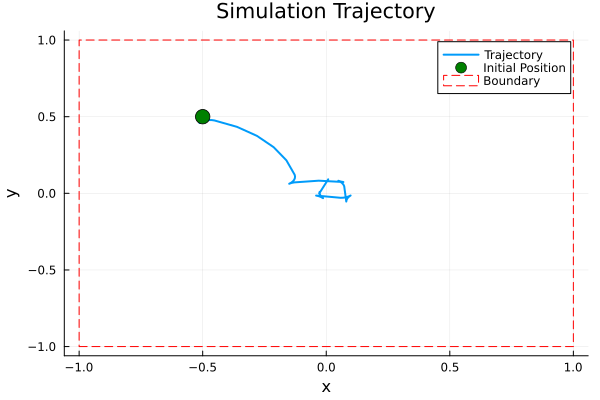

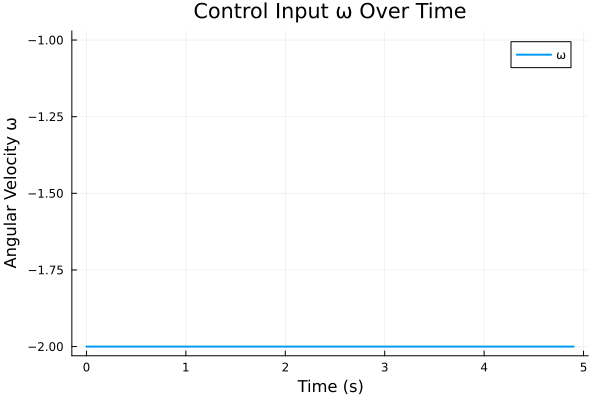

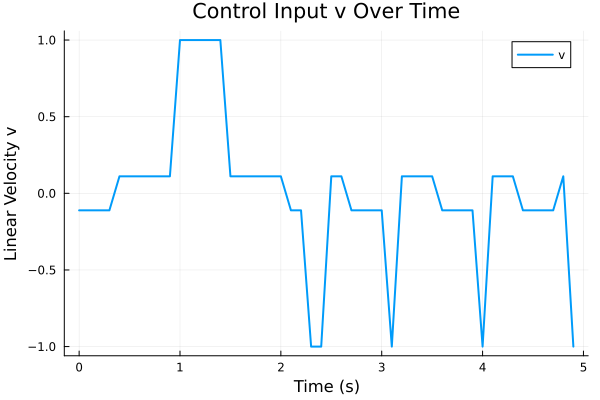

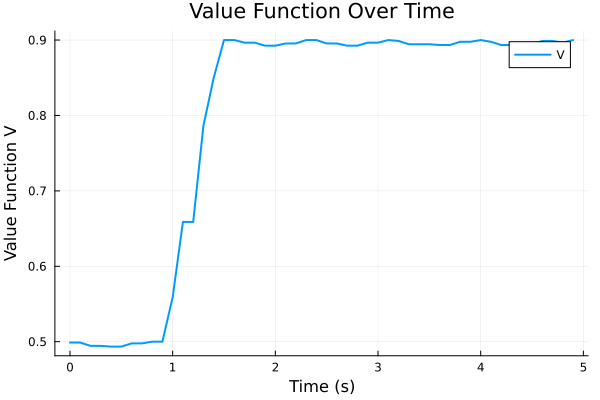

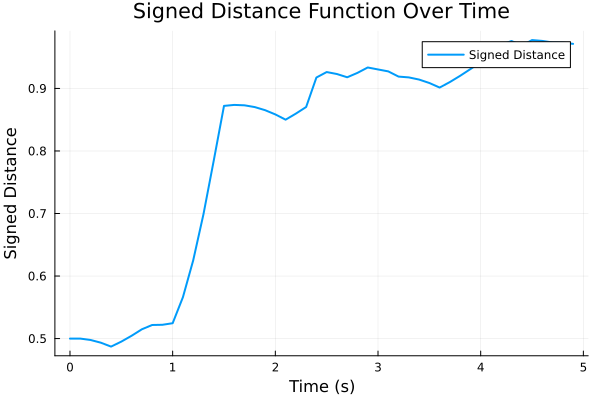

In [29]:

# Plot the trajectory
plot(
    trajectory_x, trajectory_y,
    seriestype = :path,
    xlabel = "x",
    ylabel = "y",
    title = "Simulation Trajectory",
    label = "Trajectory",
    lw = 2,
    legend = :topright
)

# Mark the initial point
scatter!(
    [trajectory_x[1]], [trajectory_y[1]],
    color = :green,
    markerstrokecolor = :black,
    markersize = 8,
    label = "Initial Position"
)

# Add boundary lines
boundary_x = [lower_x, upper_x, upper_x, lower_x, lower_x]
boundary_y = [lower_y, lower_y, upper_y, upper_y, lower_y]
plot!(
    boundary_x, boundary_y,
    seriestype = :shape,
    fillalpha = 0.0,
    linecolor = :red,
    linestyle = :dash,
    label = "Boundary"
)

savefig("trajectory_plot.png")
display(current())

# Plot omega over time
omega_over_time = [action[1] for action in inputs]
plot(
    time_points, omega_over_time,
    xlabel = "Time (s)",
    ylabel = "Angular Velocity ω",
    title = "Control Input ω Over Time",
    label = "ω",
    lw = 2,
    legend = :topright
)

savefig("omega_over_time.png")
display(current())

# Plot v over time
v_over_time = [action[2] for action in inputs]
plot(
    time_points, v_over_time,
    xlabel = "Time (s)",
    ylabel = "Linear Velocity v",
    title = "Control Input v Over Time",
    label = "v",
    lw = 2,
    legend = :topright
)

savefig("v_over_time.png")
display(current())

# Plot value function over time
plot(
    time_points, value_over_time,
    xlabel = "Time (s)",
    ylabel = "Value Function V",
    title = "Value Function Over Time",
    label = "V",
    lw = 2,
    legend = :topright
)

savefig("value_function_over_time.png")
display(current())

# Plot signed distance over time
plot(
    time_points, signed_distance_over_time,
    xlabel = "Time (s)",
    ylabel = "Signed Distance",
    title = "Signed Distance Function Over Time",
    label = "Signed Distance",
    lw = 2,
    legend = :topright
)

savefig("signed_distance_over_time.png")
display(current())